# Second task

The task is to identify the russet of the apples, or at least some part of it.

In [37]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.spatial as sc

In [38]:
image_folder_path = "./fruit-inspection-images"
images_second_task_path = os.path.join(image_folder_path, "second-task")
images_second_task = os.listdir(images_second_task_path)

ir_images = []
color_images = []

for img in images_second_task:
    if img[:2] == "C0":
        ir_images.append(img)
    else:
        color_images.append(img)

def load_image(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_COLOR)
    return image

def load_image_grey(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_GRAYSCALE)
    return image



In [39]:
def create_binary_mask(image_grey):
    _, th = cv2.threshold(image_grey, 25, 255, cv2.THRESH_BINARY)

    #Floodfill and invert
    th_copy = th.copy()
    h, w = th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(th_copy, mask, (0,0), 255)
    th_inv = cv2.bitwise_not(th_copy)
    im_out = th | th_inv

    #Smoothing the image and removing the borders
    mask = cv2.medianBlur(im_out, 3)
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv2.erode(mask, kernel, iterations = 7)
    return mask

def remove_background(image_color, binary_mask):
    image_color_copy = image_color.copy()
    for i in range(3):
        image_color_copy[:,:,i] =  binary_mask & image_color_copy[:, :, i]

    return image_color_copy


#### Detecting the russet


In order to detect the russet area we apply the Mahalanobis distance between the detected apple color and the pixels in the image. If the value is below/above a certain threshold, we assume the pixel belongs to the russet/apple area of the apple. 

In order to find a good sample color we took the mean color over all the pixels belonging to the apple only, and neglected the pixels that are all black due to the background having been removed. However, we found that since one of the apples contains more russet-pixels than "normal" apple-pixels, this turned out to "invert" the classification for this apple. So in order to correctly classify russet pixels for that apple, we had to flip the inequality.

Using the same technique on both of these apples proved difficult. One of the apples has a more reddish color, and a larger color spectrum. However, after some trial and error, we learned that dividing the mean-color by a factor, thus (in the case of LUV) making the individual colors less meaningful, we obtained better results. 

#### Trying out different color spaces

The code below uses the LUV color space of which we obtained the best results. However, we did try the LAB color space as well. We found that with different color spaces the distance thresholds changed, as well as some features were harder to detect. For example, when using the LAB color space, we found that the red area on the first apple looked very much like the russet area, and thus easily got mistaken for russet. Using the LUV color space we were able to separate the reddish color from the brown russet-color, and therefore we went on with this approach.

In [40]:
def find_russet(image, binary_mask, threshold, mostly_russet = False):
        image = cv2.medianBlur(image, 3)
        image_LUV = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)

        image_UV = image_LUV[:, :, 1:3]
        image_UV = image_UV.reshape(image_UV.shape[0] * image_UV.shape[1], 2)
        cov, mean = cv2.calcCovarMatrix(image_UV, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
        cov_inv = cv2.invert(cov, cv2.DECOMP_SVD)

        russet = np.zeros((image_LUV.shape[0], image_LUV.shape[1]))

        #find the true mean
        mask = np.array(binary_mask,dtype=bool)
        mean[0][0] = np.mean(image_LUV[:, :, 1], where = mask)
        mean[0][1] = np.mean(image_LUV[:, :, 1], where = mask)
        russet_sample = mean / image_LUV.shape[0]

        for i in range(image_LUV.shape[0]):
                for j in range(image_LUV.shape[1]):
                        pixel = np.array(image_LUV[i][j])[1:3].reshape(1, 2)
                        if(binary_mask[i][j] != 0): #calculate distance only on apple pixels
                                distance = sc.distance.cdist(pixel, russet_sample, 'mahalanobis', VI=cov_inv[1])
                                # Add 'mostly_russet' because the images are very different
                                if mostly_russet and (distance > threshold):
                                        russet[i][j] = 255
                                elif not mostly_russet and (distance < threshold):
                                        russet[i][j] = 255
        return russet.astype('uint8')

In [41]:
def is_contour_bad(contour):
    # Check if the contour is too small
    if cv2.contourArea(contour) < 100:
        return True
    return False

def extract_contours(image, rgb_image, display=True):
    _, contours, _ = cv2.findContours(image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to remove the contours that are too small
    mask = np.ones(image.shape[:2], dtype="uint8") * 255
    ellipses = []

    # Check if the contour is bad, if not add it to be drawn
    for contour in contours:
        if (is_contour_bad(contour)):
            cv2.drawContours(mask, [contour], -1, 0, -1)
        else:
            ellipses.append(cv2.fitEllipse(contour))

    # Remove the bad contours with the mask
    contours_image = cv2.bitwise_and(image, image, mask=mask)
    
    # Draw the ellipses on the original image
    for ellipse in ellipses:
        cv2.ellipse(contours_image, ellipse, (255,0,0), 50)

    if display:
        plt.figure(figsize=(16,8))
        plt.subplot(1,4,1)
        plt.imshow(image, cmap="gray", vmin=0, vmax=255)
        plt.subplot(1,4,2)
        plt.imshow(contours_image, cmap="gray", vmin=0, vmax=255)
        plt.subplot(1,4,3)
        plt.imshow(rgb_image)
        plt.subplot(1,4,4)
        display_defects(image, rgb_image)

    return contours_image


def display_defects(contours_image, rgb_image):
    alpha = 0.3
    beta = (1.0 - alpha)
    dst = cv2.addWeighted(cv2.cvtColor(contours_image, cv2.COLOR_GRAY2RGB), alpha, rgb_image, beta, 0.0)
    plt.imshow(dst, cmap="gray", vmin=0, vmax=255)
    plt.show()

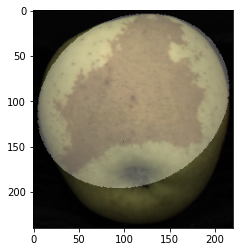

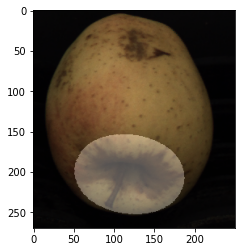

In [42]:
def spot_defect(IMAGE_NUMBER, mahalanobis_th, mostly_russet):
    image_bgr = load_image(IMAGE_NUMBER, ir=False)
    image_rgb, image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB), cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    binary_mask = create_binary_mask(image_gray)
    image_masked = remove_background(image_rgb, binary_mask)
    russet = find_russet(image_masked, binary_mask, mahalanobis_th, mostly_russet=mostly_russet)
    contours_image = extract_contours(russet, image_rgb, display=False)
    display_defects(contours_image, image_rgb)

spot_defect(1, 18, True)
spot_defect(0, 8.8, False)